> # **Bird Species Classification using CNN**

Kaggle link: [Birds](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)

# Download the dataset


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nikouts","key":"f8a7c6b4d418febcd18f14b71a38b016"}'}

In [ ]:
!mv kaggle\ \(1\).json kaggle.json

In [ ]:
!mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species --force

100% 1.89G/1.89G [00:52<00:00, 44.1MB/s]
100% 1.89G/1.89G [00:52<00:00, 39.0MB/s]


In [ ]:
! mkdir birds
! unzip 100-bird-species.zip -d birds

In [ ]:
! ls birds/ # check if everything is there

 birds.csv					 'images to predict'   train
'EfficientNetB0 model-510-(224 X 224)-99.21.h5'   test		       valid


# Load dataset and split to train/test/valid tensorflow datasets

* **First we import the necessary libraries**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow import expand_dims

* **First load the csv to take a look at the columns**

In [ ]:
df_birds = pd.read_csv(r'birds/birds.csv')
df_birds.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


**And a preview**

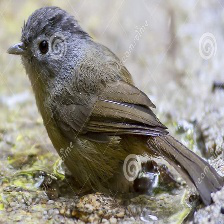

In [ ]:
# for example
PIL.Image.open('birds/' + df_birds['filepaths'][0])

* **Then we create our tensor datasets for our model**

In [ ]:
# useful variables(as constants)
batch_size = 8 # this is the number of images that will be processed before the model is updated
image_height = 224 # in pixels
image_width = 224 # in pixels
image_size = (image_height, image_width)
image_shape = (image_height, image_width, 3) # 3 is for the RGB channel(we have colored images)

In [ ]:
# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  r'birds/train', # directory
  image_size=image_size,
  batch_size=batch_size,
  shuffle = True # this shuffles the elements inside the dataset for better training
  )

# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  r'birds/test/', # directory
  image_size=image_size,
  batch_size=batch_size,
  shuffle = True 
  )

# validation test
valid_ds = tf.keras.utils.image_dataset_from_directory(
  r'birds/valid/', # directory
  image_size=image_size,
  batch_size=batch_size,
  shuffle = True
  )

Found 81950 files belonging to 510 classes.
Found 2550 files belonging to 510 classes.
Found 2550 files belonging to 510 classes.


**We have 510 classes and so 510 labels**

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TANAGER', 'AZURE TIT', 'BAIKAL TEAL', 'BALD EAGLE', 'B

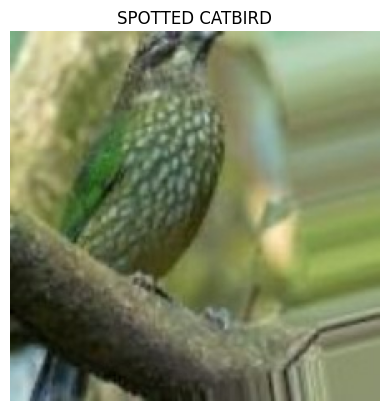

In [ ]:
class_names = train_ds.class_names # we need to keep the class names for later
print(class_names+'\n')

# let's take one element and visualize it
for image, label in train_ds.take(1):
  plt.imshow(image[0].numpy().astype("uint8"))
  plt.title(train_ds.class_names[label[0]])
  plt.axis('off')

# Creating our model

**Before building our model we need to make some configurations**

* Firstly **data augmentation**, this means we grab the pictures and create some alternatives out of each one with slightly differences, for example apply some rotation, flip, zoom in.

In [ ]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

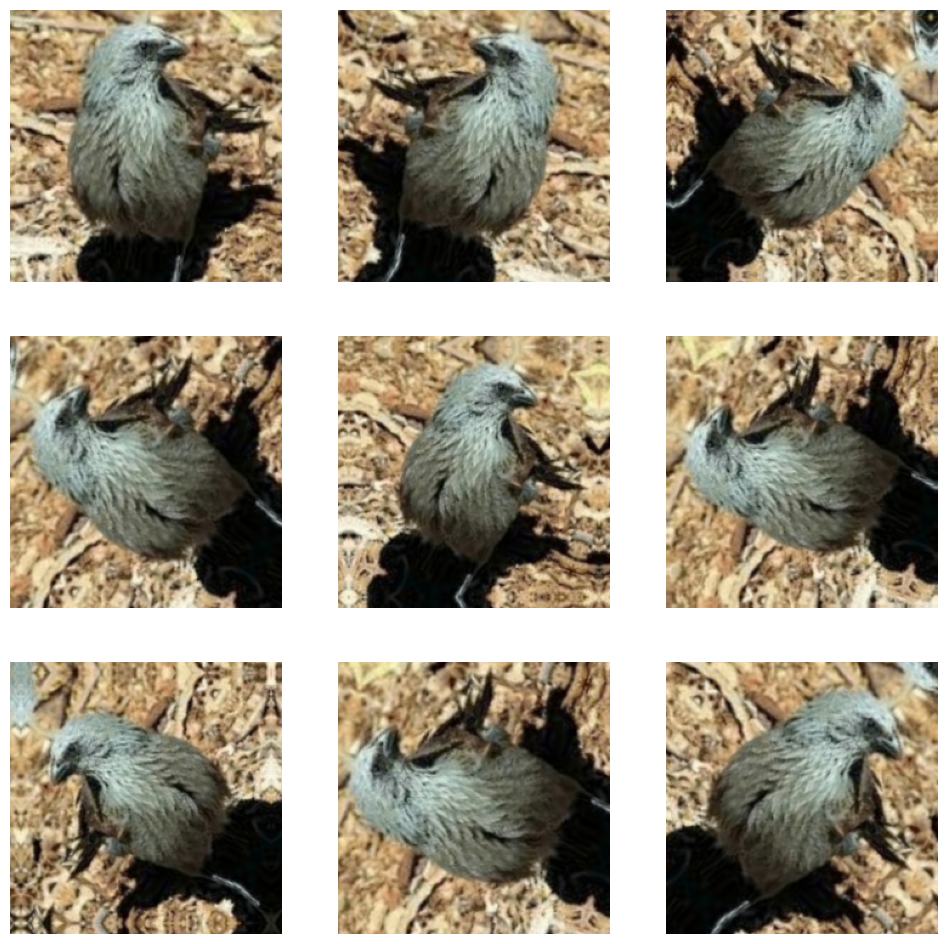

In [ ]:
# an example of a picture augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(12,12))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_img = data_augmentation(expand_dims(first_image,0))
    plt.imshow(augmented_img[0].numpy().astype('uint8'))
    plt.axis('off')

* **Base model core**

We decided to use as our base model the **EfficientNetB0** as it has already configured and pretrained weights from imagenet that hit up to 95% accuracy. 

~4 million parameters

In [ ]:
from keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top = False,
                            weights = 'imagenet',
                            input_shape = image_shape)

base_model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

* To finish the model design, we define our inputs, which will be the augmented data(of course from the train dataset), then we have the base model we created above, finally we apply pooling, a dropout and we create the last layer of our model which will be consisted of 510 neurons(amount of classes we have), we also need to set softmax for activation, to get the correct output possibilities.

In [ ]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPooling2D
from keras import Input, Model
from keras.layers import Dense, Dropout

inputs = Input(shape=image_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs,outputs)

We can have some callbacks while training our model. These are some tools that will make training much easier for us to understand what is going on.

* One very important tool is the EarlyStopping, where we can stop the training when a monitored metric has stopped improving over iterations(epochs)

* Also we will be using the TensorBoard so we can save a log of each epoch's metrics(accuracy, val_accuracy, loss, val_loss)


In [ ]:
from tensorflow.python.ops.math_ops import log
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

#path = 'birds/my_model.h5'
logpath = 'logs'

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience=10,
    verbose = 2,
    mode = 'auto'
)

# tensorflow 12.1 has a bug and can't save so i commented it out
#modelcheckpoint = ModelCheckpoint(
#    path,
#    monitor = 'val_accuracy',
#    verbose=2,
#    save_best_only=True,
#    mode='max',
#    save_weights_only=False
#)

#callbacks = [earlystop, modelcheckpoint]

callbacks = [earlystop , TensorBoard(log_dir = logpath)]

Lastly, we select our optimizer and the loss function. Here we will use Adam as optimizer function and the SparseCategoricalCrossentropy.

The reason we don't use the normal categorical_crossentropy function, is that we are not doing One Hot encoding, so we need just an index to the most probable result's category(class).

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model.compile(loss = SparseCategoricalCrossentropy(from_logits = True),
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

# Model training

* **Now some model training**

In [ ]:
history = model.fit(
    train_ds,
    epochs = 10,
    validation_data = valid_ds,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10244/10244 [==============================] - 835s 80ms/step - loss: 1.8499 - accuracy: 0.6108 - val_loss: 0.3478 - val_accuracy: 0.9055
Epoch 2/10
10244/10244 [==============================] - 809s 79ms/step - loss: 0.4673 - accuracy: 0.8782 - val_loss: 0.2347 - val_accuracy: 0.9306
Epoch 3/10
10244/10244 [==============================] - 808s 79ms/step - loss: 0.3051 - accuracy: 0.9171 - val_loss: 0.2009 - val_accuracy: 0.9447
Epoch 4/10
10244/10244 [==============================] - 809s 79ms/step - loss: 0.2317 - accuracy: 0.9352 - val_loss: 0.1892 - val_accuracy: 0.9467
Epoch 5/10
10244/10244 [==============================] - 809s 79ms/step - loss: 0.1812 - accuracy: 0.9472 - val_loss: 0.2009 - val_accuracy: 0.9443
Epoch 6/10
10244/10244 [==============================] - 808s 79ms/step - loss: 0.1526 - accuracy: 0.9554 - val_loss: 0.1929 - val_accuracy: 0.9478
Epoch 7/10
10244/10244 [==============================] - 806s 79ms/step - loss: 0.1307 - accuracy: 0.9606 - val_loss

Almost 97% accuracy!

* **See how it does with our test dataset..**

In [ ]:
model.evaluate(test_ds)

319/319 [==============================] - 10s 30ms/step - loss: 0.1058 - accuracy: 0.9702


[0.10581644624471664, 0.9701960682868958]

Not bad at all!

* **Let's take a look at the logs**

In [ ]:
history.history

{'loss': [1.8499008417129517,
  0.4672701060771942,
  0.305131733417511,
  0.23171298205852509,
  0.1811581403017044,
  0.15264692902565002,
  0.13069821894168854,
  0.11459428817033768,
  0.1043887510895729,
  0.09713633358478546],
 'accuracy': [0.6108358502388,
  0.8781574368476868,
  0.9170714020729065,
  0.9352409839630127,
  0.9471750855445862,
  0.9554240107536316,
  0.9606345295906067,
  0.9650884866714478,
  0.9679316878318787,
  0.9697986841201782],
 'val_loss': [0.3478457033634186,
  0.2346789836883545,
  0.20089086890220642,
  0.18924227356910706,
  0.20089374482631683,
  0.19288280606269836,
  0.21355296671390533,
  0.200795516371727,
  0.23529052734375,
  0.1977207064628601],
 'val_accuracy': [0.9054902195930481,
  0.9305882453918457,
  0.9447059035301208,
  0.9466666579246521,
  0.9443137049674988,
  0.9478431344032288,
  0.9431372284889221,
  0.9501960873603821,
  0.9447059035301208,
  0.9505882263183594]}

# Accuracy & Loss diagrams

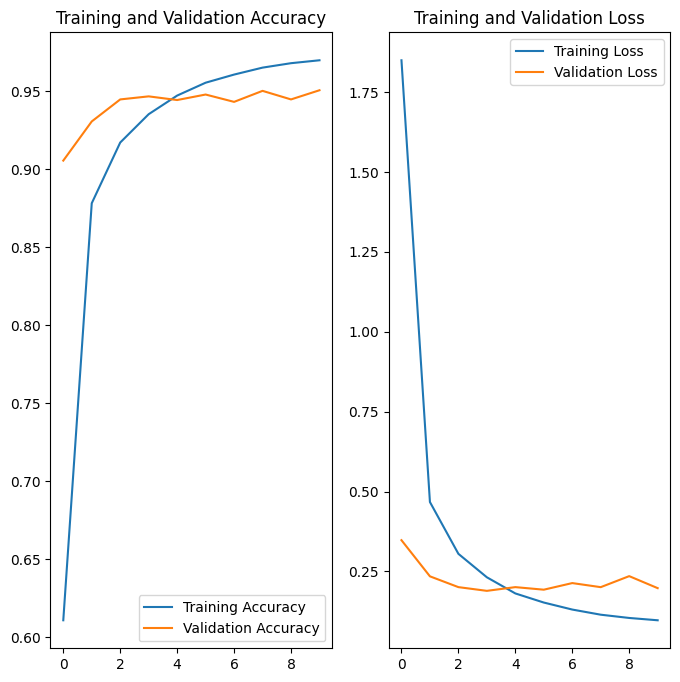

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predictions

* **First predict on a picture from the test set**

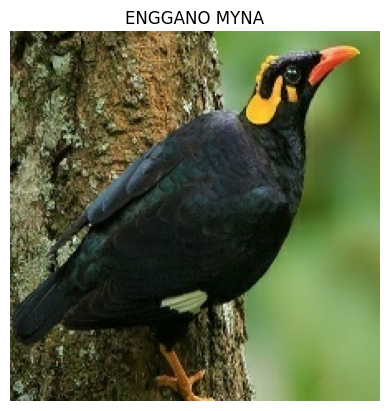

In [ ]:
# pick a random image from the test dataset with its label to predict on
for images, labels in test_ds.take(1):
  img = images[0]
  label = labels[0]
  plt.imshow(images[0]/255)
  plt.title(class_names[labels[0]])
  plt.axis('off')

In [ ]:
img.shape

TensorShape([224, 224, 3])

In [ ]:
x = expand_dims(img, axis=0) # first element is for the batch, here we have 1 image so batch = 1
x.shape

TensorShape([1, 224, 224, 3])

In [ ]:
predict = model.predict(x)
predict

1/1 [==============================] - 0s 28ms/step


array([[6.31698850e-18, 1.86565105e-13, 9.10309494e-10, 2.70673804e-15,
        2.74926841e-15, 3.77897947e-15, 2.23606005e-08, 2.84017421e-10,
        8.69732414e-14, 1.63770466e-14, 1.15253001e-19, 3.88041032e-12,
        2.35343012e-09, 1.56891320e-16, 2.39598370e-19, 3.16233889e-14,
        4.13991785e-13, 3.19630966e-14, 1.95540930e-13, 1.68514003e-14,
        9.20080647e-19, 4.98702845e-14, 5.15065800e-13, 3.43794064e-22,
        2.14918842e-19, 2.55907099e-17, 5.06482546e-15, 8.31649373e-17,
        1.01668925e-11, 6.96471238e-19, 4.63025849e-16, 1.44305403e-15,
        1.23725952e-09, 4.00798044e-16, 3.26279527e-15, 1.40971111e-16,
        1.62475539e-14, 2.63226347e-14, 6.56155428e-14, 1.46182018e-07,
        3.14877108e-15, 5.43818983e-12, 4.22785841e-19, 1.07726036e-10,
        1.09862672e-14, 5.39311899e-17, 1.08867671e-14, 2.10019295e-14,
        1.14079477e-18, 6.42180808e-17, 1.15010920e-13, 1.15445153e-14,
        1.05973745e-11, 2.51732236e-16, 1.50399007e-13, 9.590661

In [ ]:
res_accuracy = np.amax(predict[0])
res_index = np.argmax(predict[0])
res_class = class_names[res_index]

In [ ]:
print("""Bird Species: {}
Possibility: {:.4f} %""".format(res_class, (res_accuracy*100)))

Bird Species: ENGGANO MYNA
Possibility: 99.9925 %


* **predict from "images to predict" (we don't have the label here of course)**

(-0.5, 223.5, 223.5, -0.5)

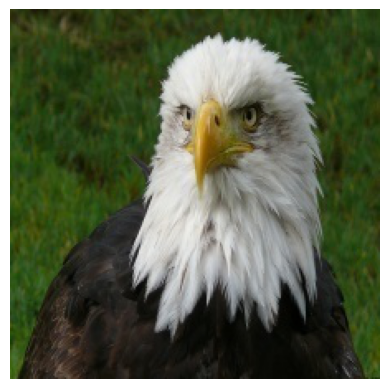

In [ ]:
pil_im = PIL.Image.open('/content/birds/images to predict/6.jpg')
pr_image = np.array(pil_im)
plt.imshow(pr_image/255)
plt.axis('off')

In [ ]:
pr_image.shape

(224, 224, 3)

In [ ]:
x = expand_dims(pr_image, axis=0)
x.shape

TensorShape([1, 224, 224, 3])

In [ ]:
predict = model.predict(x)
predict

1/1 [==============================] - 0s 28ms/step


array([[3.68413189e-23, 1.06248687e-14, 6.76792521e-20, 1.08250771e-16,
        1.26181172e-21, 1.33393509e-27, 8.99786171e-23, 1.98038433e-18,
        2.54419172e-19, 7.65595896e-15, 2.80341188e-24, 1.96737719e-21,
        2.21881247e-19, 8.32561766e-26, 2.27134865e-22, 7.72259393e-17,
        1.50805575e-20, 9.90120249e-22, 4.19952569e-21, 4.89548568e-16,
        5.91089879e-23, 3.97119783e-20, 5.49349386e-21, 1.62107609e-21,
        1.45133170e-24, 3.15509100e-15, 6.75359263e-18, 4.38288042e-24,
        7.46914331e-15, 3.32416292e-22, 5.43597663e-22, 5.55674127e-22,
        5.38129631e-24, 8.08212069e-20, 1.91202101e-19, 5.32911523e-19,
        1.15843478e-19, 5.74393961e-24, 4.63273165e-21, 2.02328638e-23,
        2.22022806e-25, 1.06640474e-15, 4.97481877e-23, 2.39859335e-21,
        2.21016501e-24, 6.80399709e-24, 1.88477821e-26, 2.51043288e-24,
        7.70099513e-26, 1.24308880e-20, 7.60237087e-25, 1.00000000e+00,
        1.03040059e-18, 1.02577384e-16, 1.65044050e-21, 4.794326

In [ ]:
res_accuracy = np.amax(predict[0])
res_index = np.argmax(predict[0])
res_class = class_names[res_index]

In [ ]:
print("""Bird Species: {}
Possibility: {:.4f} %""".format(res_class, (res_accuracy*100)))

Bird Species: BALD EAGLE
Possibility: 100.0000 %


**Correct in both cases!**